In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel('data_ori.xlsx')

Editing Date for Correction

In [3]:
from pandas.tseries.offsets import MonthEnd
# Function to correct invalid dates
def correct_invalid_dates(date_str):
    try:
        # Attempt to parse date normally
        date = pd.to_datetime(date_str, dayfirst=True)
        return date
    except ValueError:
        # If invalid, separate date and time parts
        date_part, time_part = date_str.split(' ', 1)
        
        # Split day, month, and year
        day, month, year = map(int, date_part.split('/'))
        
        # Set day to the last valid day of the month
        corrected_date = pd.to_datetime(f"{year}-{month}-01") + MonthEnd(0)
        
        # Combine with original time part
        corrected_date = pd.to_datetime(f"{corrected_date.strftime('%Y-%m-%d')} {time_part}", dayfirst=False)
        
        return corrected_date

# Apply correction function to the original data, before converting to datetime
df['Created At'] = df['Created At'].apply(lambda x: correct_invalid_dates(x))



Resolve the Inconsistencies of Product SKU#, Product Quantity, Product Price

In [4]:
filtered_df = df[df['Product SKU#'].str.contains(',', na=False)]
no_comma_df = df[~df['Product SKU#'].str.contains(',', na=False)]

# Split rows with multiple entries in SKU, Quantity, and Price columns after removing spaces and extra commas
columns_to_clean = ["Product SKU#", "Product Quantity", "Product Price"]
for col in columns_to_clean:
    filtered_df.loc[:, col] = filtered_df[col].str.replace(" ", "")

# Re-splitting with commas and exploding
df_expanded = filtered_df.set_index(["Order Number", "Recipient ID", "Country", "Recipient Postal Code", "Delivery Time", "Status", "Created At","Currency Code"]).apply(lambda x: x.str.split(",")).explode(["Product SKU#", "Product Quantity", "Product Price"]).reset_index()

# Convert numeric columns to appropriate data types after cleaning
df_expanded["Product SKU#"] = df_expanded["Product SKU#"].astype(int)
df_expanded["Product Quantity"] = df_expanded["Product Quantity"].astype(int)
df_expanded["Product Price"] = df_expanded["Product Price"].astype(float)

df_combined = pd.concat([df_expanded, no_comma_df], ignore_index=True)

Changing to Suitable Data Type for every Column

In [5]:
# Convert numeric columns to appropriate data types after cleaning
df_combined["Product SKU#"] = df_combined["Product SKU#"].astype(int)
df_combined["Product Quantity"] = df_combined["Product Quantity"].astype(int)
df_combined["Product Price"] = df_combined["Product Price"].astype(float)
df_combined["Recipient ID"] = df_combined["Recipient ID"].astype(str)
df_combined["Order Number"] = df_combined["Order Number"].astype(str)
df_combined["Status"] = df_combined["Status"].astype(str)

df_combined.sort_values(by='Order Number', ascending=True, inplace=True)

In [ ]:
# Reorder the DataFrame columns
column_order = [
    "Order Number", "Recipient ID", "Country", "Recipient Postal Code", 
    "Product SKU#", "Product Quantity", "Product Price", 
    "Currency Code", "Delivery Time", "Status", "Created At"
]
df_combined = df_combined[column_order]

# Save the cleaned data to an Excel file
df_combined.to_excel('data_cleaned.xlsx', index=False)

General Insights

In [ ]:
# Calculate the total number of unique customers
total_unique_customers = df_combined['Recipient ID'].nunique()

# Calculate the total number of unique postal codes
total_unique_postal_codes = df_combined['Recipient Postal Code'].nunique()

# Calculate the total number of orders
total_orders = df_combined['Order Number'].nunique()  

total_unique_products = df_combined['Product SKU#'].nunique()

total_revenue = df_combined['Product Price'].sum()

print("Total Number of Unique Customers:", total_unique_customers)
print("Total Number of Unique Postal Codes:", total_unique_postal_codes)
print("Total Number of Orders:", total_orders)
print("Total Number of Products:", total_unique_products)
print("Total Revenue:", total_revenue)

Total Number of Unique Customers: 308
Total Number of Unique Postal Codes: 536
Total Number of Orders: 1102
Total Number of Products: 19
Total Revenue: 386042.0


Customer Segmentation

In [ ]:
# Ensure 'Order Date' is in datetime format
df_combined['Created At'] = pd.to_datetime(df_combined['Created At'])

# Define a reference date for recency calculation (e.g., today's date or the last date in the dataset)
reference_date = df_combined['Created At'].max()

# RFM Analysis
rfm = df_combined.groupby('Recipient ID').agg(
    Recency=('Created At', lambda x: (reference_date - x.max()).days), # Days since last order
    Frequency=('Order Number', 'nunique'),  # Count of unique orders per customer
    Monetary=('Product Price', 'sum')        # Sum of order amounts for each customer
).reset_index()

# Define thresholds for segmentation (using quantiles here for example)
frequency_threshold = rfm['Frequency'].quantile(0.75)
monetary_threshold = rfm['Monetary'].quantile(0.75)
recency_threshold = rfm['Recency'].quantile(0.25)  # Lower recency is better in this case

# Function to categorize customers
def segment_rfm(row):
    if row['Frequency'] > frequency_threshold and row['Recency'] <= recency_threshold:
        return 'Loyal Customer'
    elif row['Frequency'] > frequency_threshold and row['Monetary'] < monetary_threshold:
        return 'Frequent Shopper'
    elif row['Monetary'] > monetary_threshold:
        return 'Bulk Buyer'
    else:
        return 'Inactive Customer'

# Apply the segmentation function
rfm['Segment'] = rfm.apply(segment_rfm, axis=1)

In [ ]:
# Save the RFM analysis to an Excel file
rfm.to_excel('rfm_analysis.xlsx', index=False)

Data Visualisation

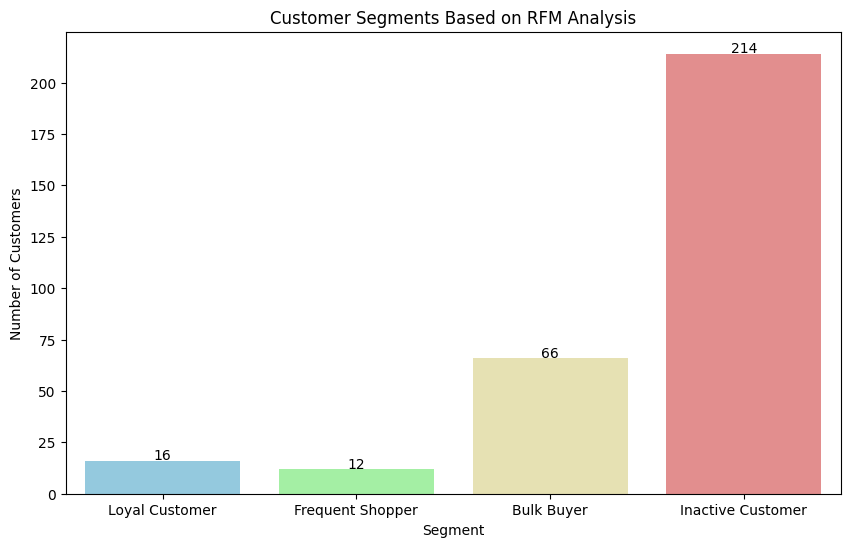

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the custom color palette
custom_palette = {
    'Loyal Customer': 'skyblue',
    'Frequent Shopper': 'palegreen',
    'Bulk Buyer': 'palegoldenrod',
    'Inactive Customer': 'lightcoral'
}

# Define the order of the segments
order = ['Loyal Customer','Frequent Shopper', 'Bulk Buyer', 'Inactive Customer']

# Plotting the count of customers in each segment with custom colors and order
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=rfm, x='Segment', order=order, hue='Segment', palette=custom_palette, dodge=False)
plt.title('Customer Segments Based on RFM Analysis')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.legend([],[], frameon=False)  # Remove the legend

# Add data labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,  # X position
        height + 0.5,                   # Y position, slightly above the bar
        int(height),                    # Display height as integer
        ha='center'                     # Center align text horizontally
    )

plt.show()

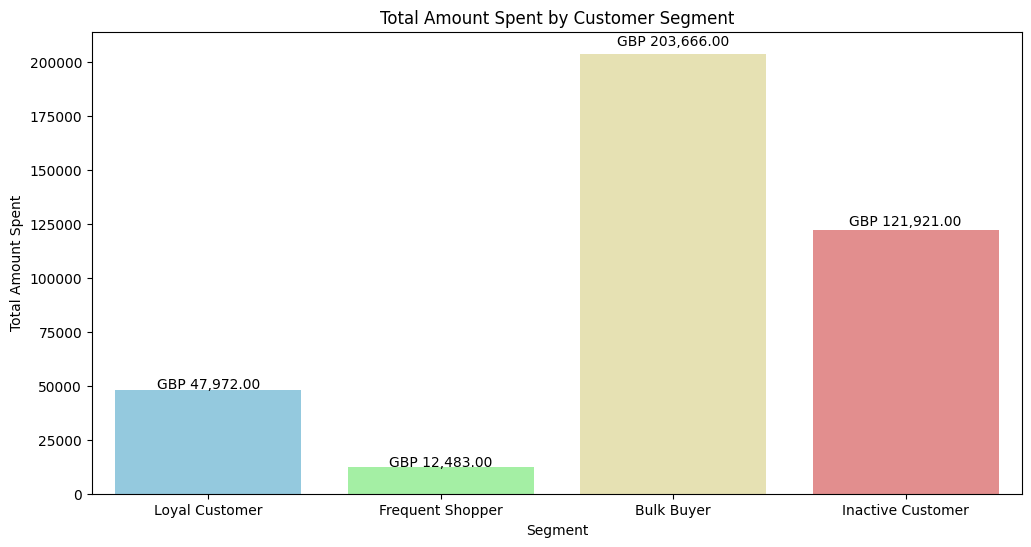

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate the total spend by segment
spend_by_segment = rfm.groupby('Segment')['Monetary'].sum().reindex(order).reset_index()

# Define the custom color palette
custom_palette = {
    'Loyal Customer': 'skyblue',
    'Frequent Shopper': 'palegreen',
    'Bulk Buyer': 'palegoldenrod',
    'Inactive Customer': 'lightcoral'
}

# Plotting the total amount spent in each segment with custom colors and order
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=spend_by_segment, x='Segment', y='Monetary', palette=custom_palette, order=order)
plt.title('Total Amount Spent by Customer Segment')
plt.xlabel('Segment')
plt.ylabel('Total Amount Spent')

# Add data labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,  # X position
        height + 0.02 * height,         # Y position, slightly above the bar
        f'GBP {height:,.2f}',              # Display total spent as formatted currency
        ha='center'                     # Center align text horizontally
    )

plt.show()

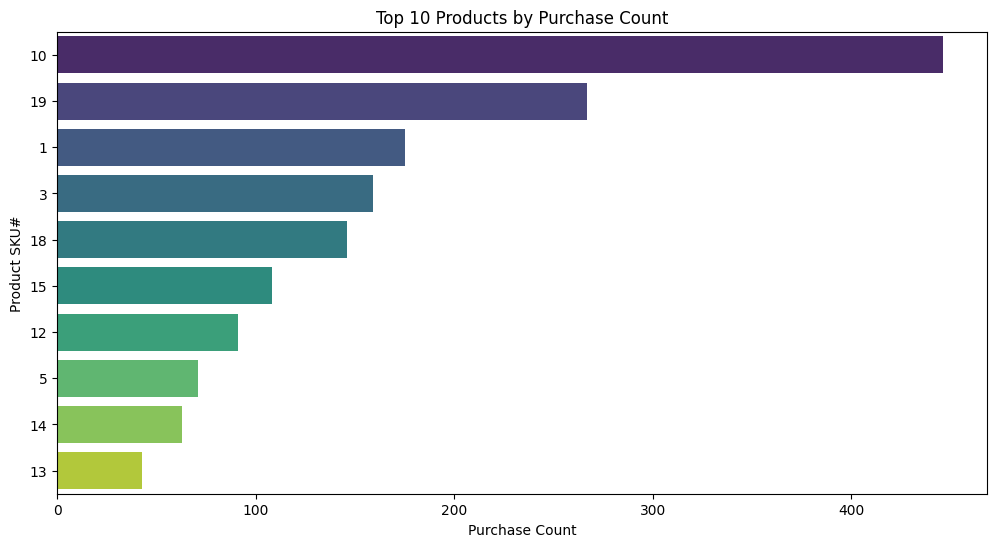

In [148]:
# Calculate the frequency of each SKU
top_products = df_combined['Product SKU#'].value_counts().reset_index()
top_products.columns = ['Product SKU#', 'Product Quantity']

# Sort by Product Quantity in descending order and select the top 10 products
top_10_products = top_products.sort_values(by='Product Quantity', ascending=False).head(10)

# Manually specify the order of the bars
order = top_10_products['Product SKU#']

# Plot the top products by purchase count in horizontal orientation with a specified order
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_products, y='Product SKU#', x='Product Quantity', palette="viridis", orient='h', order=order)
plt.title("Top 10 Products by Purchase Count")
plt.xlabel("Purchase Count")
plt.ylabel("Product SKU#")
plt.show()


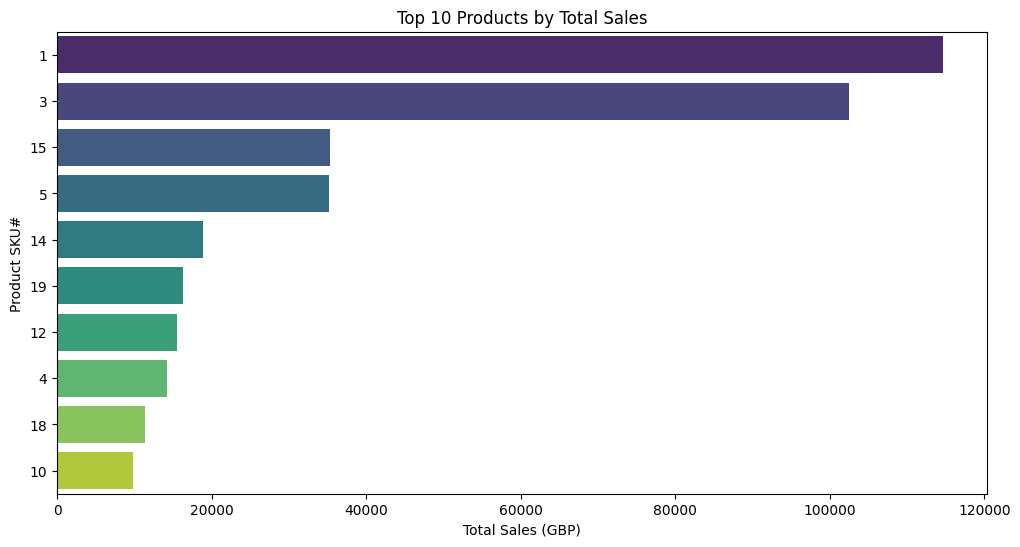

In [151]:
# Calculate the total quantity ordered for each SKU
top_products = df_combined.groupby('Product SKU#')['Product Price'].sum().reset_index()
top_products.columns = ['Product SKU#', 'Total Sales']

# Sort by Total Quantity Ordered in descending order and select the top 10 products
top_10_products = top_products.sort_values(by='Total Sales', ascending=False).head(10)

# Manually specify the order of the bars
order = top_10_products['Product SKU#']

# Plot the top products by total quantity ordered in horizontal orientation with a specified order
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_products, y='Product SKU#', x='Total Sales', palette="viridis", orient='h', order=order)
plt.title("Top 10 Products by Total Sales")
plt.xlabel("Total Sales (GBP)")
plt.ylabel("Product SKU#")
plt.show()

Market Basket Analysis with Apriori

In [ ]:
import pandas as pd
import warnings
from mlxtend.frequent_patterns import apriori, association_rules

def perform_market_basket_analysis(df, min_support=0.01, min_lift=1):
    """
    Perform market basket analysis on transaction data.
    
    Parameters:
    df: DataFrame with columns ['Order Number', 'Product SKU#']
    min_support: Minimum support threshold for frequent itemsets (default: 0.01)
    min_lift: Minimum lift threshold for strong rules (default: 1.5)
    
    Returns:
    tuple: (frequent_itemsets, strong_rules)
    """
    # Suppress deprecation warnings
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    
    # Create a pivot table with Order Number as rows and each SKU as columns
    basket = (df.groupby(['Order Number', 'Product SKU#'])
             .size()
             .unstack(fill_value=0))
    
    # Convert quantities to boolean (True if product was purchased)
    basket = basket > 0
    
    # Convert to int type (required for some versions of mlxtend)
    basket = basket.astype(int)
    
    # Step 1: Apply the Apriori algorithm to find frequent itemsets
    frequent_itemsets = apriori(basket, 
                              min_support=min_support, 
                              use_colnames=True)
    
    # Step 2: Generate association rules with num_itemsets parameter
    rules = association_rules(frequent_itemsets, 
                            metric="lift",
                            min_threshold=1,
                            num_itemsets=len(frequent_itemsets))
    
    # Step 3: Filter rules for strong associations
    strong_rules = rules[rules['lift'] > min_lift]
    
    # Sort rules by lift in descending order
    strong_rules = strong_rules.sort_values('lift', ascending=False)
    
    return frequent_itemsets, strong_rules

def display_results(strong_rules, n=10):
    """
    Display the top n association rules in a formatted way.
    
    Parameters:
    strong_rules: DataFrame containing the association rules
    n: Number of top rules to display (default: 10)
    """
    print(f"\nTop {n} Association Rules:")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    
    display_rules = strong_rules[['antecedents', 'consequents', 
                                'support', 'confidence', 'lift']].head(n)
    
    # Convert frozenset to string for better readability
    display_rules['antecedents'] = display_rules['antecedents'].apply(lambda x: list(x))
    display_rules['consequents'] = display_rules['consequents'].apply(lambda x: list(x))
    
    print(display_rules)

In [154]:
frequent_itemsets, strong_rules = perform_market_basket_analysis(df_combined)
display_results(strong_rules)


Top 10 Association Rules:
  antecedents consequents   support  confidence      lift
4        [10]        [15]  0.062613    0.154709  1.639315
5        [15]        [10]  0.062613    0.663462  1.639315
3         [5]        [10]  0.039020    0.623188  1.539806
2        [10]         [5]  0.039020    0.096413  1.539806
1         [3]        [10]  0.068058    0.493421  1.219170
0        [10]         [3]  0.068058    0.168161  1.219170
6        [10]        [19]  0.103448    0.255605  1.108965
7        [19]        [10]  0.103448    0.448819  1.108965


Market Trend Visualisation

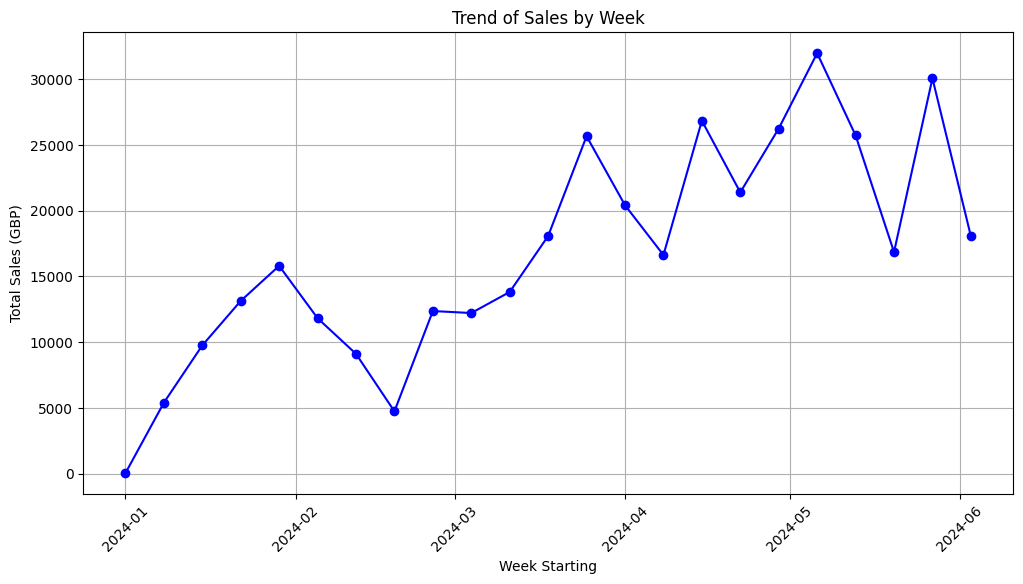

In [161]:
import matplotlib.pyplot as plt

# Ensure 'Created At' column is in datetime format
df_combined['Created At'] = pd.to_datetime(df_combined['Created At'])

# Calculate weekly sales by summing up 'Product Price' column per week
weekly_sales = df_combined.resample('W-Mon', on='Created At')['Product Price'].sum().reset_index()
weekly_sales.columns = ['Week Starting', 'Total Sales']

# Plotting the trend of sales by week
plt.figure(figsize=(12, 6))
plt.plot(weekly_sales['Week Starting'], weekly_sales['Total Sales'], marker='o', color='b')
plt.title("Trend of Sales by Week")
plt.xlabel("Week Starting")
plt.ylabel("Total Sales (GBP)")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()


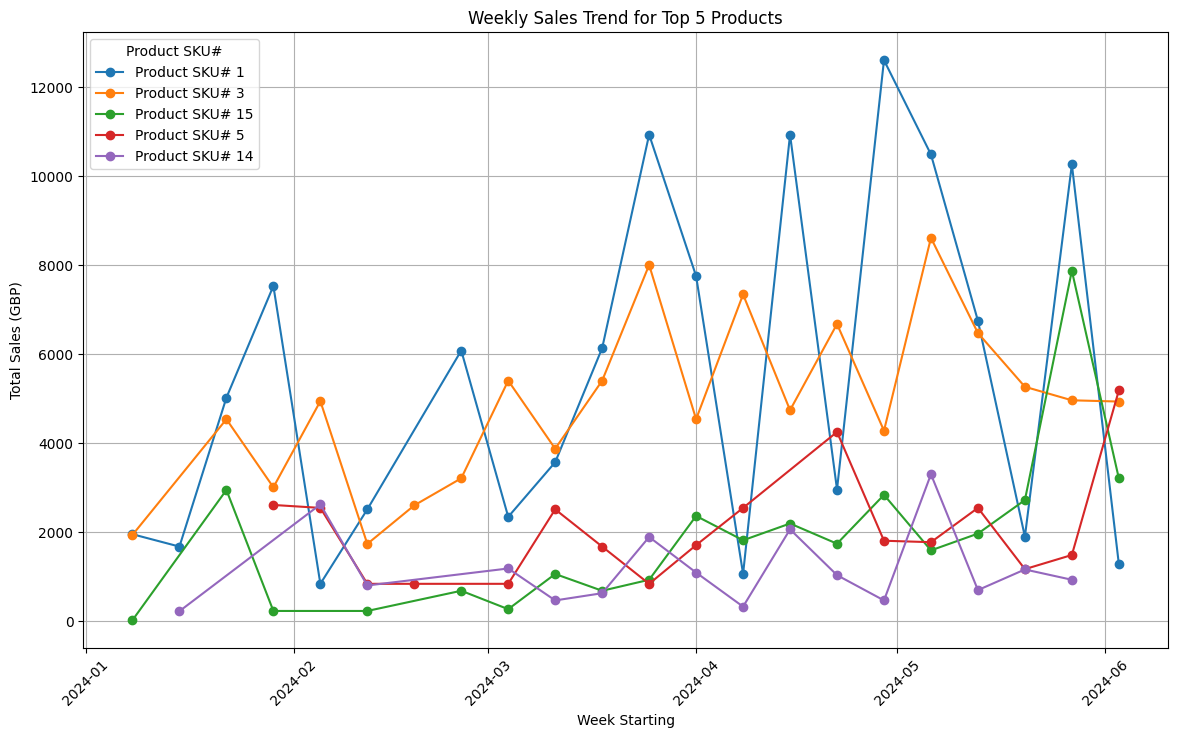

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'Created At' is in datetime format
df_combined['Created At'] = pd.to_datetime(df_combined['Created At'])

# Update the year in the 'Created At' column to 2024
df_combined['Created At'] = df_combined['Created At'].apply(lambda x: x.replace(year=2024))

# Calculate total sales per product (SKU) to identify the top 5 products
top_products = df_combined.groupby('Product SKU#')['Product Price'].sum().nlargest(5).index

#Filter the data for only the top 5 products
top_5_products_data = df_combined[df_combined['Product SKU#'].isin(top_products)]

# Calculate weekly sales for each of the top 5 products
weekly_sales_by_product = top_5_products_data.groupby(['Product SKU#', pd.Grouper(key='Created At', freq='W-Mon')])['Product Price'].sum().reset_index()

# Plot weekly sales trend for each of the top 5 products
plt.figure(figsize=(14, 8))
for product in top_products:
    product_data = weekly_sales_by_product[weekly_sales_by_product['Product SKU#'] == product]
    plt.plot(product_data['Created At'], product_data['Product Price'], marker='o', label=f'Product SKU# {product}')

plt.title("Weekly Sales Trend for Top 5 Products")
plt.xlabel("Week Starting")
plt.ylabel("Total Sales (GBP)")
plt.xticks(rotation=45)
plt.legend(title="Product SKU#")
plt.grid(True)
plt.show()

Regional Analysis

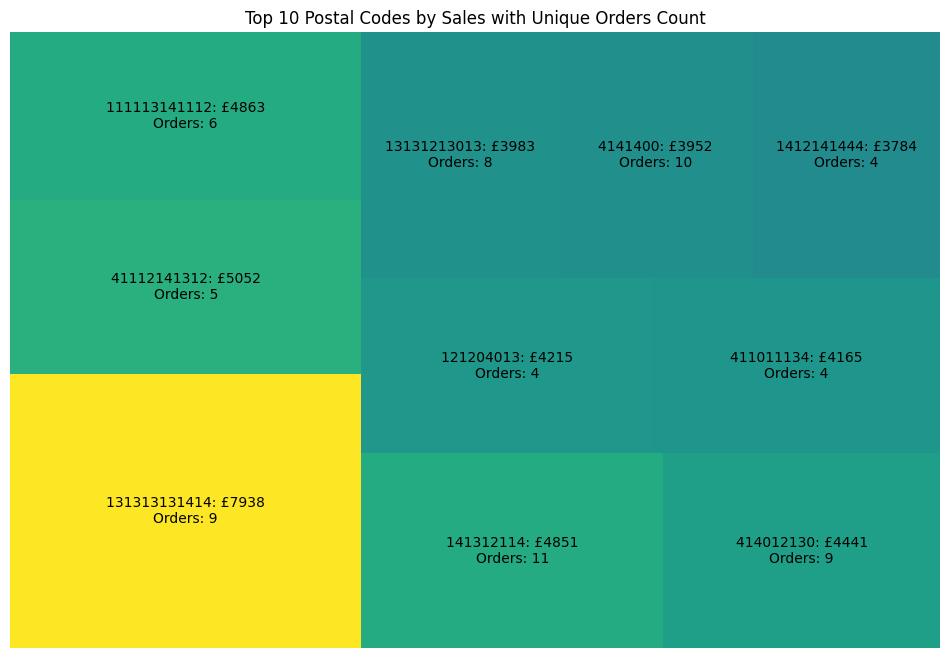

In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import squarify

# Calculate total sales and unique order count by postal code
sales_by_postcode = df_combined.groupby('Recipient Postal Code').agg({
    'Product Price': 'sum',  # Total sales per postal code
    'Order Number': 'nunique'  # Count of unique orders per postal code
}).reset_index()

sales_by_postcode.columns = ['Recipient Postal Code', 'Total Sales', 'Unique Orders']

# Convert postal code to string and remove '.0' if present
sales_by_postcode['Recipient Postal Code'] = sales_by_postcode['Recipient Postal Code'].apply(lambda x: str(int(x)) if isinstance(x, float) else str(x))

# Sort data by total sales and select the top 10 postal codes
top_10_sales_by_postcode = sales_by_postcode.sort_values(by='Total Sales', ascending=False).head(10)

# Format labels to show postal codes, total sales, and unique orders
labels = [f"{pc}: £{int(sales)}\nOrders: {orders}" for pc, sales, orders in 
          zip(top_10_sales_by_postcode['Recipient Postal Code'], 
              top_10_sales_by_postcode['Total Sales'], 
              top_10_sales_by_postcode['Unique Orders'])]

# Plotting the treemap for top 10 postal codes with total sales and unique orders
plt.figure(figsize=(12, 8))
squarify.plot(sizes=top_10_sales_by_postcode['Total Sales'], 
              label=labels, 
              color=plt.cm.viridis(top_10_sales_by_postcode['Total Sales'] / max(top_10_sales_by_postcode['Total Sales'])))
plt.title("Top 10 Postal Codes by Sales with Unique Orders Count")
plt.axis('off')
plt.show()


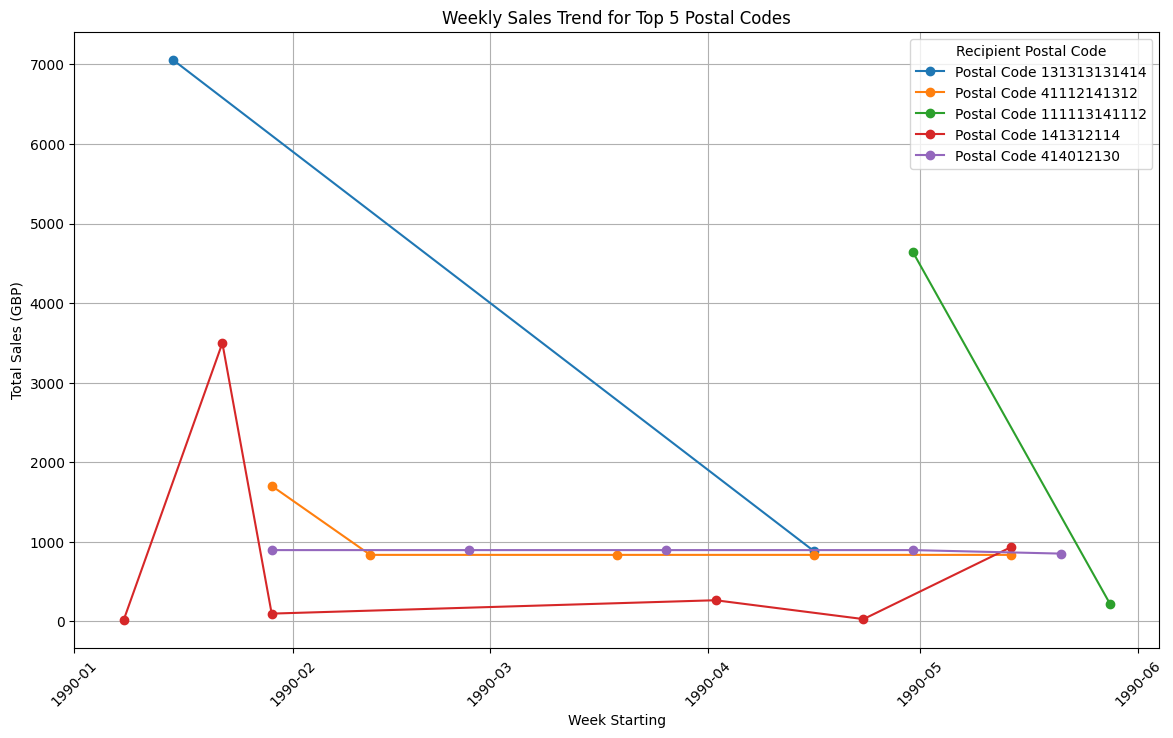

In [159]:
# Calculate total sales by postal code
sales_by_postcode = df_combined.groupby('Recipient Postal Code')['Product Price'].sum().reset_index()
sales_by_postcode.columns = ['Recipient Postal Code', 'Total Sales']

# Filter for top 5 postal codes based on total sales
top_5_postcodes = sales_by_postcode.sort_values(by='Total Sales', ascending=False).head(5)['Recipient Postal Code']

# Filter data for only top 5 postcodes
top_5_data = df_combined[df_combined['Recipient Postal Code'].isin(top_5_postcodes)]

# Calculate weekly sales for each of the top 5 postal codes
weekly_sales_by_postcode = top_5_data.groupby(['Recipient Postal Code', pd.Grouper(key='Created At', freq='W-Mon')])['Product Price'].sum().reset_index()

# Plot weekly sales trend for each top postal code
plt.figure(figsize=(14, 8))
for postcode in top_5_postcodes:
    postcode_data = weekly_sales_by_postcode[weekly_sales_by_postcode['Recipient Postal Code'] == postcode]
    plt.plot(postcode_data['Created At'], postcode_data['Product Price'], marker='o', label=f'Postal Code {postcode}')

plt.title("Weekly Sales Trend for Top 5 Postal Codes")
plt.xlabel("Week Starting")
plt.ylabel("Total Sales (GBP)")
plt.xticks(rotation=45)
plt.legend(title="Recipient Postal Code")
plt.grid(True)
plt.show()